# Introduction and setup

Import neccessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import itertools
from IPython.display import display_html
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Helper functions.

In [2]:
def parse_datetime(date, time):
    return datetime.strptime(date + ' ' + time, '%d.%m.%Y %H:%M')

def parse_time(time):
    return datetime.strptime(time, '%H:%M').time()

def add_datetime_column(df):
    df['datetime'] = df.apply(lambda x: parse_datetime(x.Date, x.Timestamp), axis=1)
    
def add_time_column(df):
    df['time'] = df.apply(lambda x: parse_time(x.Timestamp), axis=1)
    
def set_concise_formatter(ax):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# Following method code taken from: 
# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

Read in the data. Subject 1 = Behrad, Subject 2 = Gregor, Subject 3 = Kaarel

In [3]:
def read_data(test_type):
    results = []
    for i in range(1,8): 
        filepath = "data/" + test_type + "_subject_" + str(i) + ".csv"
        results.append(pd.read_csv(filepath))
    return results
        

reaction_subjects_data = read_data('reaction')
visual_subjects_data = read_data('visual')
typing_subjects_data = read_data('typing')


# Add 'datetime' column to dataframes
[add_datetime_column(df) for df in reaction_subjects_data]
[add_datetime_column(df) for df in visual_subjects_data]
[add_datetime_column(df) for df in typing_subjects_data]


# Add 'time' column to dataframes
[add_time_column(df) for df in reaction_subjects_data]
[add_time_column(df) for df in visual_subjects_data]
[add_time_column(df) for df in typing_subjects_data]


# Create data dictionary
total_data = {
    'reaction': reaction_subjects_data,
    'visual': visual_subjects_data,
    'typing': typing_subjects_data
}

Let's have look at the shapes of dataframes, general statistics of each test type and total data points. Also lets plot them on scatter plots.

In [4]:
def print_shapes(test_type):
    print(test_type + " shapes:", list(map(lambda x: x.shape, total_data[test_type])))

In [5]:
print_shapes('reaction')
print_shapes('visual')
print_shapes('typing')

reaction shapes: [(50, 5), (29, 5), (38, 5), (50, 5), (50, 5), (50, 5), (50, 5)]
visual shapes: [(60, 5), (29, 5), (38, 5), (50, 5), (50, 5), (50, 5), (50, 5)]
typing shapes: [(60, 5), (33, 5), (38, 5), (50, 5), (50, 5), (50, 5), (50, 5)]


In [6]:
concatted_data = [pd.concat(dfs) for dfs in [total_data['reaction'], total_data['visual'], total_data['typing']]]
display_side_by_side(*[df.describe() for df in concatted_data])

,result
count,317.000000
mean,246.785489
std,19.086198
min,186.000000
25%,233.000000
50%,248.000000
75%,260.000000
max,299.000000
,result
count,327.000000


In [7]:
total_df = pd.concat(list(itertools.chain(*total_data.values())), sort=False)
print("Total data points shape:", total_df.shape)
total_df.head()

Total data points shape: (975, 5)


,Date,Timestamp,result,datetime,time
0,18.11.2019,18:57,267,2019-11-18 18:57:00,18:57:00
1,18.11.2019,12:29,268,2019-11-18 12:29:00,12:29:00
2,18.11.2019,18:06,282,2019-11-18 18:06:00,18:06:00
3,18.11.2019,12:08,272,2019-11-18 12:08:00,12:08:00
4,18.11.2019,14:35,276,2019-11-18 14:35:00,14:35:00


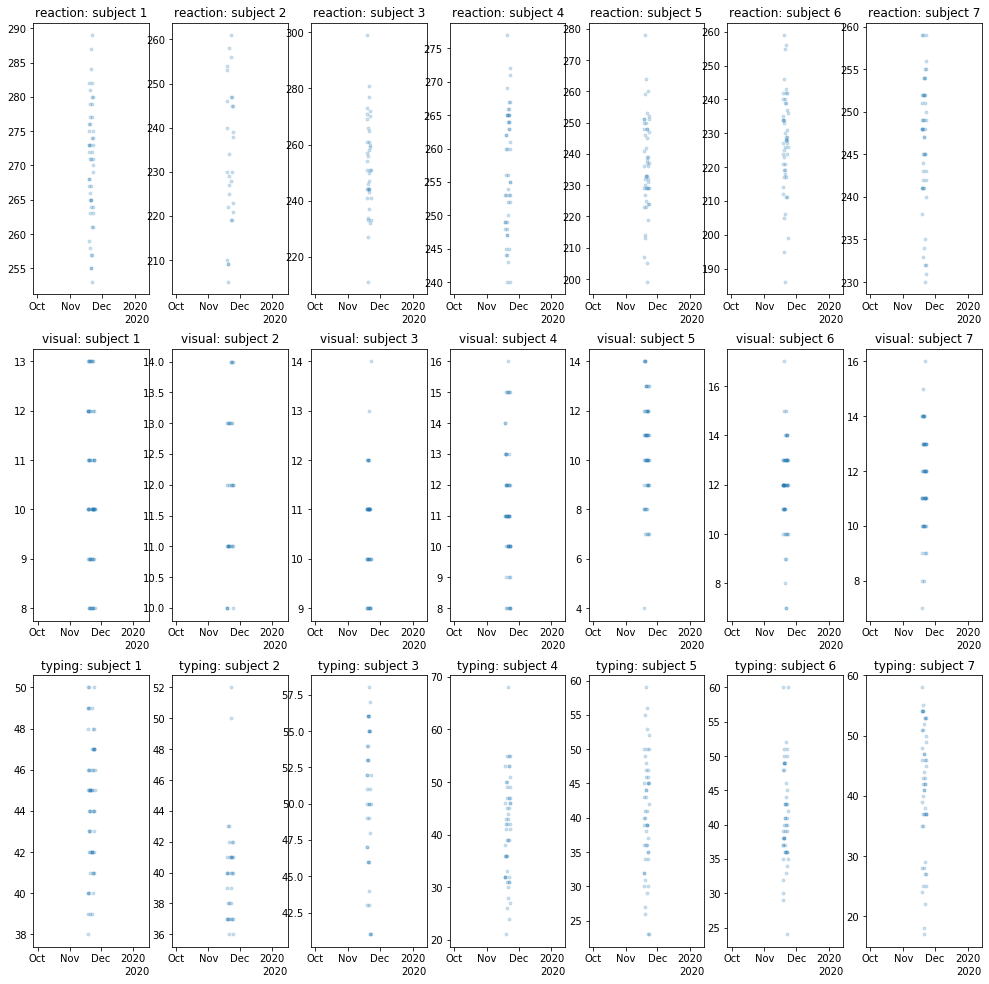

In [8]:
fig, axs = plt.subplots(3, 7, figsize=(17, 17))

for i, (test_type, ax) in enumerate(zip(np.repeat(['reaction', 'visual', 'typing'], 7), itertools.chain(*axs))):
    index = i % 7
    d = total_data[test_type][index]
    ax.scatter(d.datetime, d.result, marker='.', alpha=0.2)
    set_concise_formatter(ax)
    ax.set_title(test_type + ": subject " + str(index + 1))
        
plt.show()

## Performance throughout the day

First, let's have look at two-hour interval average performance of **reaction** time test of all the subjects.

In [9]:
# Combine all subjects reaction data into single dataframe
reaction_data = pd.concat(total_data['reaction'])


# Set 'datetime' column as dateframe index for making it possible resample based on it
reaction_data.set_index(reaction_data['datetime'], inplace=True)
reaction_data = reaction_data.loc['2019-11-18':'2019-11-22'] # Disgarding data from 23rd and 24th November since only present for one subject

two_hour_interval_result_means = reaction_data.resample('2H').mean().dropna() # Two-hour interval 'result' means, dropping NaN results
daily_result_means = reaction_data.resample('D').mean() # Daily 'result' means
reaction_data.describe()

,result
count,308.000000
mean,247.155844
std,19.154993
min,186.000000
25%,233.750000
50%,248.000000
75%,261.000000
max,299.000000


Plot two-hour frequency averages for each day.

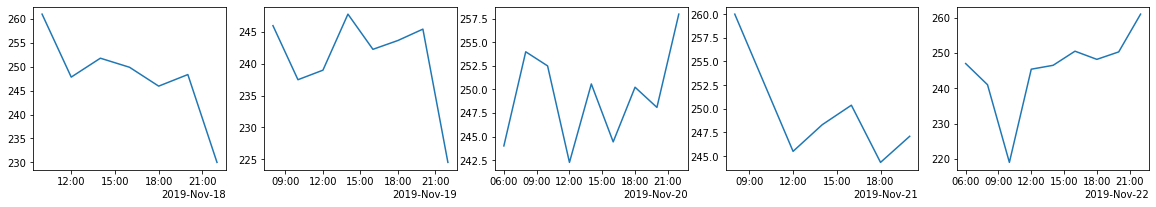

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20,3))
for day, ax in zip(range(18, 23), axs):
    data = two_hour_interval_result_means.loc['2019-11-' + str(day)] # Get data for single day
    ax.plot(data.index, data.result)
    for ax in axs:
        set_concise_formatter(ax)
        
plt.show()

From the charts above it can be seen that reaction time got better in the evening. There are spikes at evening on all days except on 20 Nov. It seems that in the morning brain is not yet at its best performance and it gets better as the day progresses.

In order to validate this lets discard the dates and look at the results as they happened on a single day.

In [11]:
reaction_data['time'] = reaction_data.apply(lambda x: datetime.strptime(x.Timestamp, '%H:%M'), axis=1)
reaction_data.set_index(reaction_data['time'], inplace=True)
reaction_hourly_data = reaction_data.resample('2H').mean().dropna()
reaction_hourly_data

,result
time,
1900-01-01 06:00:00,245.500000
1900-01-01 08:00:00,251.000000
1900-01-01 10:00:00,243.333333
1900-01-01 12:00:00,244.391304
1900-01-01 14:00:00,248.971429
1900-01-01 16:00:00,246.964286
1900-01-01 18:00:00,247.301587
1900-01-01 20:00:00,247.814815
1900-01-01 22:00:00,242.666667


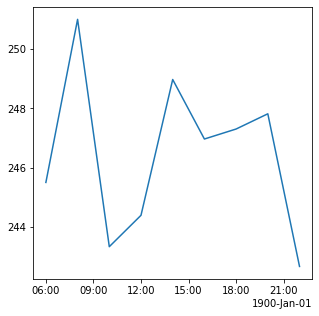

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(reaction_hourly_data.index, reaction_hourly_data.result)
set_concise_formatter(ax)
plt.show()

From the plot it can be seen that as the day progresses performance of reaction time increases. Lets repeat same also for visual and typing tests.

In [13]:
visual_data = pd.concat(total_data['visual'])

visual_data.set_index(visual_data['datetime'], inplace=True)
visual_data = visual_data.loc['2019-11-18':'2019-11-22'] # Disgarding data from 23rd and 24th November since only present for one subject

visual_2h_means = visual_data.resample('2H').mean().dropna() # Two-hour interval 'result' means, dropping NaN results

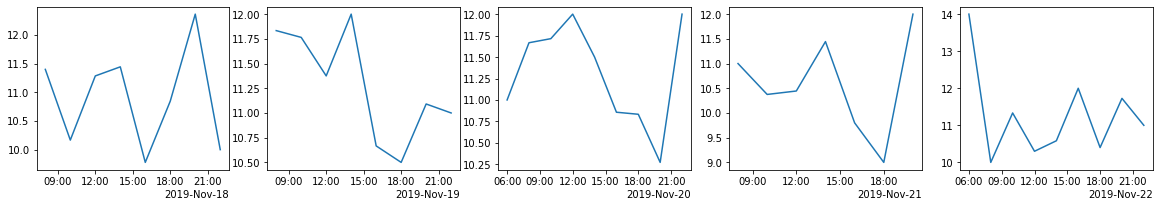

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(20,3))
for day, ax in zip(range(18, 23), axs):
    data = visual_2h_means.loc['2019-11-' + str(day)] # Get data for single day
    ax.plot(data.index, data.result)
    for ax in axs:
        set_concise_formatter(ax)
        
plt.show()

In [15]:
visual_data['time'] = visual_data.apply(lambda x: datetime.strptime(x.Timestamp, '%H:%M'), axis=1)
visual_data.set_index(visual_data['time'], inplace=True)
visual_hourly_data = visual_data.resample('2H').mean().dropna()
visual_hourly_data

,result
time,
1900-01-01 06:00:00,12.500000
1900-01-01 08:00:00,11.533333
1900-01-01 10:00:00,11.245283
1900-01-01 12:00:00,11.148148
1900-01-01 14:00:00,11.151515
1900-01-01 16:00:00,10.346154
1900-01-01 18:00:00,10.675676
1900-01-01 20:00:00,11.508772
1900-01-01 22:00:00,11.166667


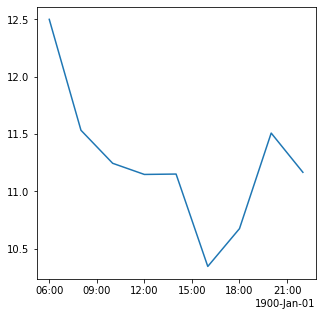

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(visual_hourly_data.index, visual_hourly_data.result)
set_concise_formatter(ax)
plt.show()

In case of visual test the last plot indicates that time-of-day cycle affects the results so that as the day progresses, the results are descending.

In [17]:
typing_data = pd.concat(total_data['typing'])

typing_data.set_index(typing_data['datetime'], inplace=True)
typing_data = typing_data.loc['2019-11-18':'2019-11-22'] # Disgarding data from 23rd and 24th November since only present for one subject

typing_2h_means = typing_data.resample('2H').mean().dropna() # Two-hour interval 'result' means, dropping NaN results

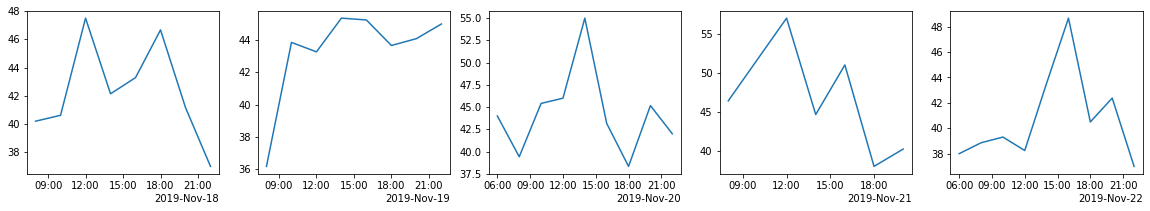

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(20,3))
for day, ax in zip(range(18, 23), axs):
    data = typing_2h_means.loc['2019-11-' + str(day)] # Get data for single day
    ax.plot(data.index, data.result)
    for ax in axs:
        set_concise_formatter(ax)
        
plt.show()

In [19]:
typing_data['time'] = typing_data.apply(lambda x: datetime.strptime(x.Timestamp, '%H:%M'), axis=1)
typing_data.set_index(typing_data['time'], inplace=True)
typing_hourly_data = typing_data.resample('2H').mean().dropna()
typing_hourly_data

,result
time,
1900-01-01 06:00:00,41.000000
1900-01-01 08:00:00,39.857143
1900-01-01 10:00:00,42.120690
1900-01-01 12:00:00,43.650000
1900-01-01 14:00:00,44.309091
1900-01-01 16:00:00,44.609756
1900-01-01 18:00:00,40.464286
1900-01-01 20:00:00,42.192982
1900-01-01 22:00:00,41.333333


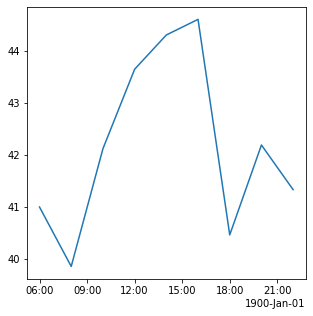

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(typing_hourly_data.index, typing_hourly_data.result)
set_concise_formatter(ax)
plt.show()

## Comparison of subjects

First, lets have look at basic statistics of each subject on different tests.

In [21]:
display_side_by_side(*[df.describe() for df in total_data['reaction']])

,result
count,50.000000
mean,270.320000
std,8.693042
min,253.000000
25%,264.250000
50%,271.000000
75%,276.000000
max,289.000000
,result
count,29.000000


Subject 2 is most performant in reaction test having the best reaction time (**min**) and best **mean**. Subject 1 is most consistent having the lowest standard deviation.

In [22]:
display_side_by_side(*[df.describe() for df in total_data['visual']])

,result
count,60.000000
mean,10.366667
std,1.594128
min,8.000000
25%,9.000000
50%,10.000000
75%,12.000000
max,13.000000
,result
count,29.000000


Subject 2 has the best mean and also has best third quartile, which shows consistency in higher results as well. Subject 3 has same maximum result as Subject 2, but his third quartile value indicates that higher values were not so regular for him.

In [23]:
display_side_by_side(*[df.describe() for df in total_data['typing']])

,result
count,60.000000
mean,44.366667
std,3.129773
min,38.000000
25%,42.000000
50%,45.000000
75%,47.000000
max,50.000000
,result
count,33.000000


Subject 3 has performed the best in typing test having highest max value and best mean.

Following plots are for every subject and test separately. The dates information is disgarded and the trials are counted as they happened on one day (this is why x-axis date label is 1900-Jan-01).

In [24]:
np.repeat(range(8), 3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
       7, 7])

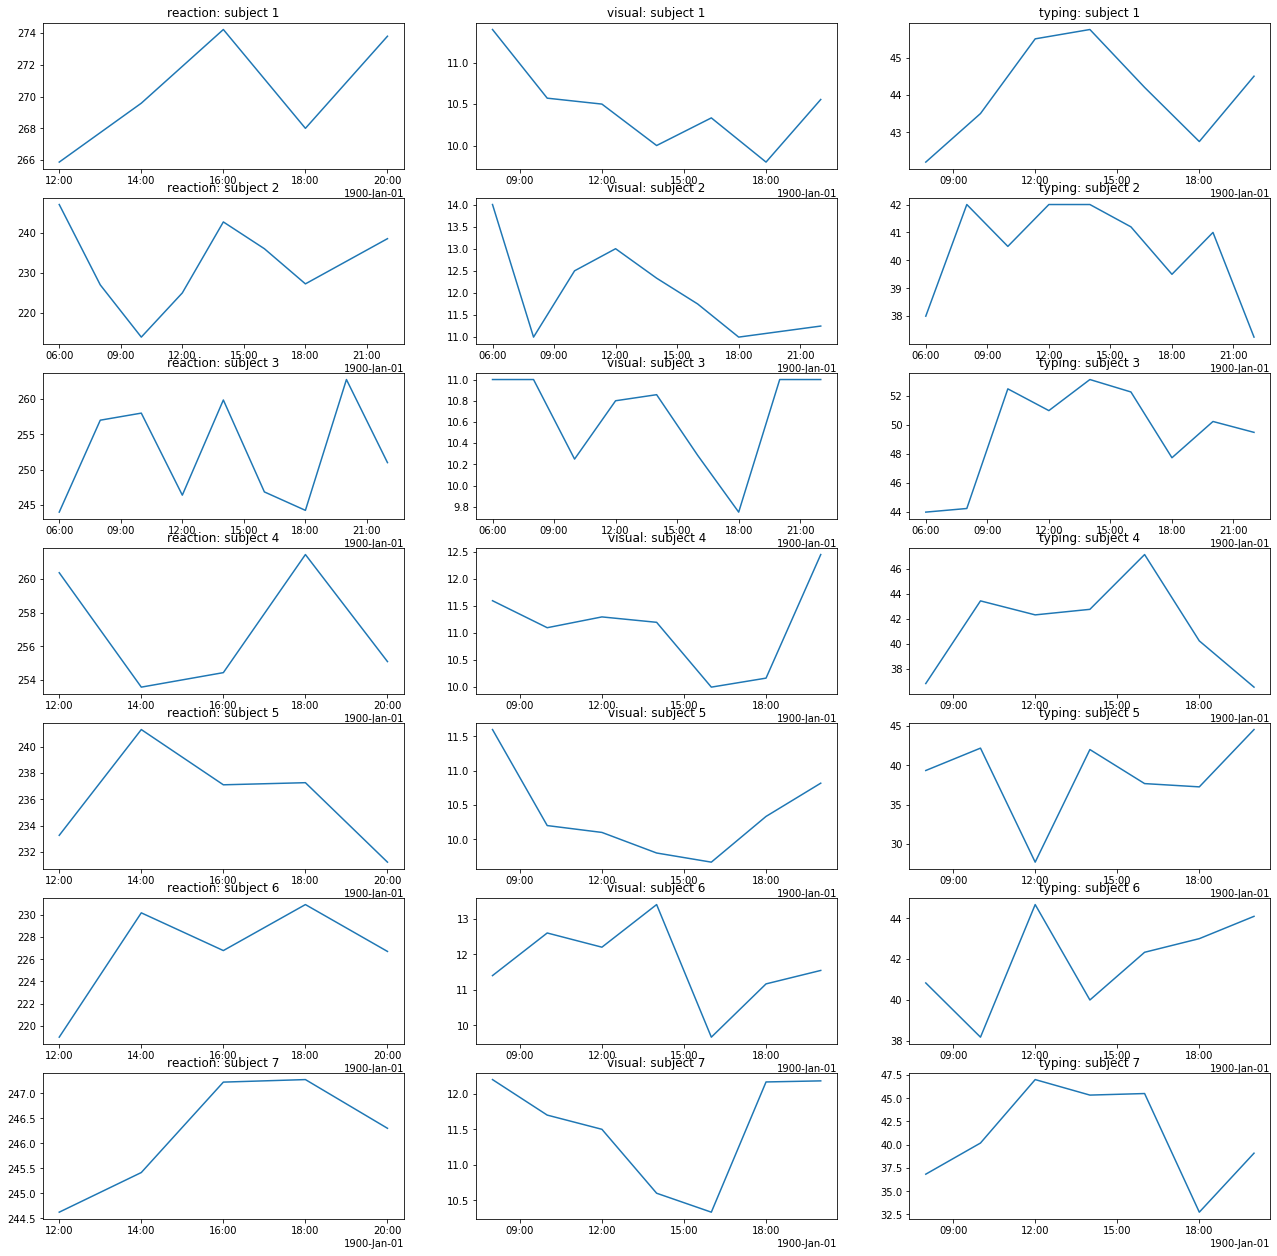

In [25]:
fig, axs = plt.subplots(7, 3, figsize=(22, 22))
test_types = ['reaction', 'visual', 'typing']
for i, (ax, index) in enumerate(zip(itertools.chain(*axs), np.repeat(range(8), 3))):
    #index = i % 7
    i2 = i % 3
    test_type = test_types[i2]
    d = total_data[test_type][index]
    dfc = d.copy(deep=True)
    dfc.set_index(dfc['datetime'], inplace=True)
    dfc = dfc.loc['2019-11-18':'2019-11-22']
    dfc['time'] = dfc.apply(lambda x: datetime.strptime(x.Timestamp, '%H:%M'), axis=1)
    dfc.set_index(dfc['time'], inplace=True)
    dfs = dfc.resample('2H').mean().dropna()
    ax.plot(dfs.index, dfs.result)
    set_concise_formatter(ax)
    ax.set_title(test_type + ": subject " + str(index + 1))
        
plt.show()

Reaction test plots here are controversial to the one where subjects results were plotted together indicating that in the evening the reaction time gets better. Here it shows that subjects have up-and-downs through-out the day, so it seems that individually the time-of-day didn't have significant effect on the reaction time.

On the visual test it is also draw any proof giving conclusions.

Typing test plots shapes indicate that in the middle of the day the results seems to be better, morning and evening less so.

Of course it is arguable that one day is as perfomant as another. Lets have look at how subjects performed on daily basis.

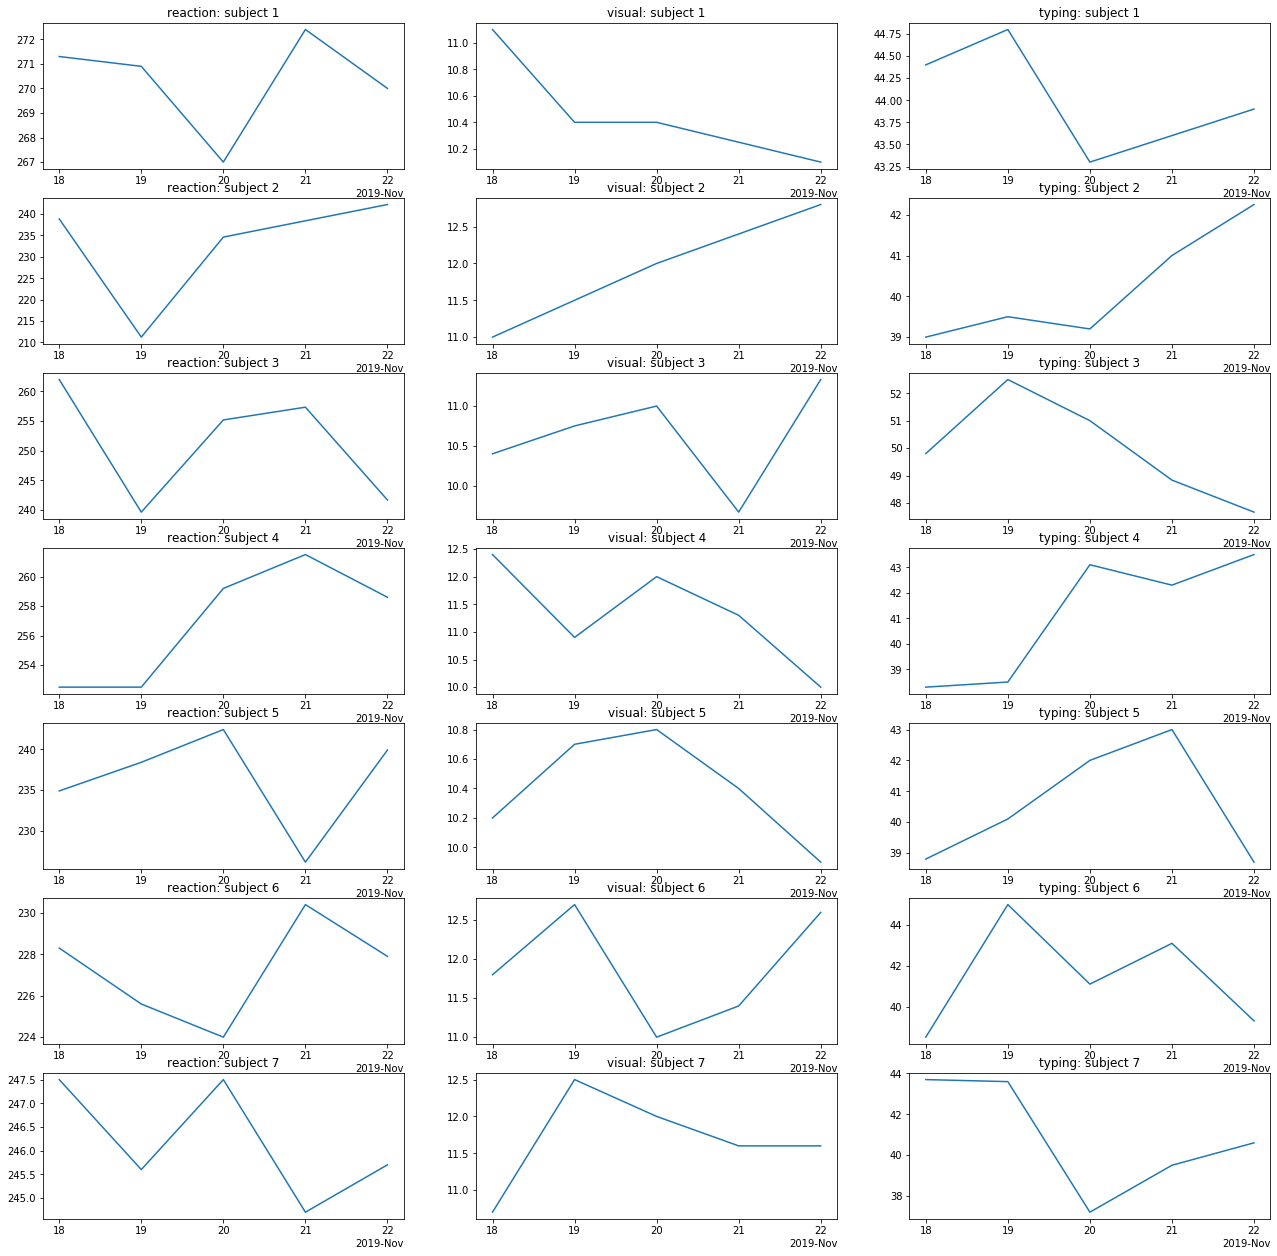

In [26]:
fig, axs = plt.subplots(7, 3, figsize=(22, 22))
test_types = ['reaction', 'visual', 'typing']

daily_data = {
    'reaction': [],
    'visual': [],
    'typing': []
}

for i, (ax, index) in enumerate(zip(itertools.chain(*axs), np.repeat(range(8), 3))):
    i2 = i % 3
    test_type = test_types[i2]
    d = total_data[test_type][index]
    dfc = d.copy(deep=True)
    dfc.set_index(dfc['datetime'], inplace=True)
    dfc = dfc.loc['2019-11-18':'2019-11-22']
    dfs = dfc.resample('D').mean().dropna()
    daily_data[test_type].append(dfs)
    ax.plot(dfs.index, dfs.result)
    set_concise_formatter(ax)
    ax.set_title(test_type + ": subject " + str(index + 1))
        
plt.show()

In [27]:
display_side_by_side(*[df.describe() for df in daily_data['reaction']])
display_side_by_side(*[df.describe() for df in daily_data['visual']])
display_side_by_side(*[df.describe() for df in daily_data['typing']])

,result
count,5.000000
mean,270.320000
std,2.046216
min,267.000000
25%,270.000000
50%,270.900000
75%,271.300000
max,272.400000
,result
count,4.000000


,result
count,4.000000
mean,10.500000
std,0.424264
min,10.100000
25%,10.325000
50%,10.400000
75%,10.575000
max,11.100000
,result
count,4.000000


,result
count,4.000000
mean,44.100000
std,0.648074
min,43.300000
25%,43.750000
50%,44.150000
75%,44.500000
max,44.800000
,result
count,5.000000
